# Compare the General Performance of CABG
 - Create a dataframe containing the severity of stenosis using FFR, and if the stenosis subtended territory is ischemic.
 - Add the point-based or voxel-based MBF value to the data-frame (or create a new one?)
 - Violin Plots:
    - Pre/Post MBF against ischemic-grafted, non-ischemic-grafted, non-ischemic nongrafted
    - Pre/Post MBF against severity of stenosis (none, mild, moderate, severe)

In [44]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
from utilities import ReadVTUFile, ThresholdInBetween, ThresholdByUpper, LargestConnectedRegion, WriteVTUFile
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

In [50]:
path = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy"
opath = os.path.join(path,"MappedPreCABG")
os.system(f"mkdir {opath}")
metadata = glob.glob(f"{path}/*.xlsx")
VTUFiles = sorted(glob.glob(f"{path}/*.vtu"))
TerritoryLabels = sorted(glob.glob(f"{path}/*.dat"))
print(VTUFiles)

PatientMetadata = pd.read_excel(metadata[0], dtype={'column_name': str})
print(PatientMetadata)

['/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU03A_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU03B_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU04A_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU04B_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU06A_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU06B_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU07A_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU07B_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU11A_MBF_Territories.vtu', '/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy/SU11B_MBF_Territories.vtu', '/Users/ana/Documen

In [3]:
patient_ids = sorted(set(PatientMetadata["patient-id"]))
print(patient_ids)

['SU03', 'SU04', 'SU06', 'SU07', 'SU11', 'SU13', 'SU14', 'SU23', 'SU24', 'SU25', 'SU26', 'SU27', 'SU28', 'SU30', 'VA02', 'VA04', 'VA10', 'VA13', 'VA14', 'VA16']


In [4]:
def ReadLabels(InputLabels, TerritoryTag):
    MBF_Labels = {}
    for tag in TerritoryTag:
        MBF_Labels[tag] =  []
    MBF_Labels["Nongrafted-Stenosis"] = []
    MBF_Labels["Nongrafted"] = []
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.strip().split()
            label = line[1]
            id_value = int(line[0])
            found = False

            for key in TerritoryTag:
                if key in label: 
                    MBF_Labels[key].append(id_value)
                    found = True
            
            if not found:
                if "NG" in label:
                    MBF_Labels["Nongrafted-Stenosis"].append(id_value)
                    found = True
                else:
                    MBF_Labels["Nongrafted"].append(id_value)

    MBF_Labels = {k.replace('post_', ''):v for k,v in MBF_Labels.items() if len(v)>0}
    
    return MBF_Labels

def robust_mode(data, bins=50):
    counts, bin_edges = np.histogram(data, bins=bins)
    max_bin_index = np.argmax(counts)
    mode_value = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    return mode_value

def Normalize(MBF, method="mode", cutoff = 50):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ArrayName = arrayname_
    
    ScalarArray = vtk_to_numpy(MBF.GetPointData().GetArray(ArrayName))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(MBF, ArrayName, cutoff))
    HealthyMyo = LargestConnectedRegion(ThresholdInBetween(MBF, ArrayName, cutoff, np.percentile(ScalarArray,90)))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(HealthyMyo, ArrayName, cutoff))
    ScalarArray_healthy = vtk_to_numpy(HealthyMyo.GetPointData().GetArray(ArrayName))
    
    if method == "mode": # Histogram Analysis
        # Using Freedman-Diaconis Rule to calculate the number of bins based on IQR
        IQR = np.percentile(ScalarArray_healthy, 75) - np.percentile(ScalarArray_healthy, 25)
        bin_width = 2*IQR/(len(ScalarArray_healthy))**(1/3)
        MBF_range = np.max(ScalarArray_healthy) - np.min(ScalarArray_healthy)
        bins = int(MBF_range/bin_width)
        ref_MBF = robust_mode(ScalarArray_healthy, bins)
    elif method == "median":
        ref_MBF = np.median(ScalarArray_healthy)
    elif method == "mean":
        ref_MBF = np.mean(ScalarArray_healthy)
    elif method == "old":
        ref_MBF = np.percentile(ScalarArray, 75)
    elif method == "zscore":
        q1, q2, q3 = np.percentile(ScalarArray_healthy, [25, 50, 75])
        IndexMBFArray = (ScalarArray - q2)/(q3 - q1)
        IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
        IndexMBF = numpy_to_vtk(IndexMBFArray)
        IndexMBF.SetName("IndexMBF")
        MBF.GetPointData().AddArray(IndexMBF)

        return MBF
    else:
        ref_MBF = np.percentile(ScalarArray_healthy, 75)

    IndexMBFArray = ScalarArray/ref_MBF
    IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
    IndexMBF = numpy_to_vtk(IndexMBFArray)
    IndexMBF.SetName("IndexMBF")
    MBF.GetPointData().AddArray(IndexMBF)

    return MBF


def CollectMBFData(MBF, Labels):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
            arrayname_ = MBF.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    AbsMBFData = {}
    IndexMBFData = {}
    for key in Labels.keys():
        AbsMBFData[key] = np.array([])
        IndexMBFData[key] = np.array([])
        for i in Labels[key]:
            territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
            MBF_ = vtk_to_numpy(territory_.GetPointData().GetArray(ScalarArray))
            iMBF_ = vtk_to_numpy(territory_.GetPointData().GetArray("IndexMBF"))
            AbsMBFData[key] = np.append(AbsMBFData[key], MBF_)
            IndexMBFData[key] = np.append(IndexMBFData[key], iMBF_)
    

    return AbsMBFData, IndexMBFData

def BoxPlot(DataFrame):
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(x='Territories', y='MBF', hue='Type', data= DataFrame, showfliers=False, palette={'A':'skyblue', 'B':'salmon'})

    ax.set_ylabel("Index MBF", fontsize = 20)
    ax.tick_params(axis='x', rotation=10, labelsize=15)
    ax.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()

def ViolinPlot(DataFrame):
    plt.figure(figsize=(10, 6))

    sns.violinplot(x='Territories', y='MBF', hue='Type', data = DataFrame, split=True, inner = 'quartiles', bw_adjust = 10, common_norm=True, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})

    plt.ylabel("Absolute MBF")
    #plt.xlabel("Group")
    plt.legend(title="Pre/Post CABG")
    #plt.ylim([-0.5, 3])
    plt.show()




In [5]:
print(PatientMetadata[PatientMetadata['patient-id'] == 'SU03']['stenosis tag'])

0    Diag
1     LAD
2     RCA
Name: stenosis tag, dtype: object


# Implementing Normalization: SKIP RUNNING THIS SECTION

In [ ]:
data = []
for patient_id in patient_ids:
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff == 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    for i, t in enumerate(tags):
        data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": ischemia[i], "absMBF_A": AbsMBFData_A[t], "absMBF_B": AbsMBFData_B[t], "IndexMBF_A": IndexMBFData_A[t], "IndexMBF_B": IndexMBFData_B[t]}
        data.append(data_)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": False, "absMBF_A": AbsMBFData_A[t], "absMBF_B": AbsMBFData_B[t], "IndexMBF_A": IndexMBFData_A[t], "IndexMBF_B": IndexMBFData_B[t]}
        data.append(data_)
    t = "Nongrafted"
    data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": False, "absMBF_A": AbsMBFData_A[t], "absMBF_B": AbsMBFData_B[t], "IndexMBF_A": IndexMBFData_A[t], "IndexMBF_B": IndexMBFData_B[t]}
    data.append(data_)

df = pd.DataFrame(data)
df


In [ ]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
index_mbf_ischemic_A = np.concatenate(df[df['is_ischemic'] == True]['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_A, [25, 50, 75])
average = np.mean(index_mbf_ischemic_A)
std = np.std(index_mbf_ischemic_A)
print("ischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_ischemic_B = np.concatenate(df[df['is_ischemic'] == True]['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_B, [25, 50, 75])
average = np.mean(index_mbf_ischemic_B)
std = np.std(index_mbf_ischemic_B)
print("ischemic_grafted_B",q2, q3-q1, average, std)

index_mbf_nonischemic_A = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_A, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_A)
std = np.std(index_mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_nonischemic_B = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_B, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_B)
std = np.std(index_mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)

index_mbf_st_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_st_nongrafted_A, [25, 50, 75])
average = np.mean(index_mbf_st_nongrafted_A)
std = np.std(index_mbf_st_nongrafted_A)
print("stenosed_nongrafted_A", q2, q3-q1, average, std)

index_mbf_st_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_st_nongrafted_B, [25, 50, 75])
average = np.mean(index_mbf_st_nongrafted_B)
std = np.std(index_mbf_st_nongrafted_B)
print("stenosed_nongrafted_B", q2, q3-q1, average, std)


index_mbf_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted']['IndexMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_A, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_A)
std = np.std(index_mbf_nongrafted_A)
print("nongrafted_A", q2, q3-q1, average, std)

index_mbf_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted']['IndexMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_B, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_B)
std = np.std(index_mbf_nongrafted_B)
print("nongrafted_B", q2, q3-q1, average, std)


In [ ]:
# Create a DataFrame with each part
df_A = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_A, index_mbf_nonischemic_A, index_mbf_st_nongrafted_A, index_mbf_nongrafted_A]),
    'Territory': ['Ischemic Grafted'] * len(index_mbf_ischemic_A) + 
             ['Non-ischemic Grafted'] * len(index_mbf_nonischemic_A) + 
             ['Nongrafted Stenosis'] * len(index_mbf_st_nongrafted_A) +
             ['Nongrafted'] * len(index_mbf_nongrafted_A),
    'Type': ['A'] * (len(index_mbf_ischemic_A) + len(index_mbf_nonischemic_A) + len(index_mbf_st_nongrafted_A) + len(index_mbf_nongrafted_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_B, index_mbf_nonischemic_B, index_mbf_st_nongrafted_B, index_mbf_nongrafted_B]),
    'Territory': ['Ischemic Grafted'] * len(index_mbf_ischemic_B) + 
             ['Non-ischemic Grafted'] * len(index_mbf_nonischemic_B) + 
             ['Nongrafted Stenosis'] * len(index_mbf_st_nongrafted_B) +
             ['Nongrafted'] * len(index_mbf_nongrafted_B),
    'Type': ['B'] * (len(index_mbf_ischemic_B) + len(index_mbf_nonischemic_B) + len(index_mbf_st_nongrafted_B) + len(index_mbf_nongrafted_B))
})

# Combine into a single DataFrame
df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(10, 6))

sns.violinplot(x='Territory', y='MBF', hue='Type', data = df_long, split=True, inner = 'quartiles', bw_adjust = 10, common_norm=True, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})

plt.ylabel("Index MBF")
#plt.xlabel("Group")
plt.legend(title="Pre/Post CABG")
plt.ylim([-3, 4.5])
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, palette={'A':'skyblue', 'B':'salmon'})

ax.set_ylabel("Index MBF", fontsize = 20)
ax.tick_params(axis='x', rotation=0, labelsize=10)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [ ]:
for patient_id in patient_ids:
    print(patient_id)
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    data = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    for i, t in enumerate(tags):
        array_A = IndexMBFData_A[t]
        array_B = IndexMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        array_A = IndexMBFData_A[t]
        array_B = IndexMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
    t = "Nongrafted"
    array_A = IndexMBFData_A[t]
    array_B = IndexMBFData_B[t]
    data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    data = pd.concat([data, data_], ignore_index=True)
    #BoxPlot(data)
    ViolinPlot(data)


# Mapping Pre-CABG on Post-CABG based on the Distribution of Nongrafted regions

SU03


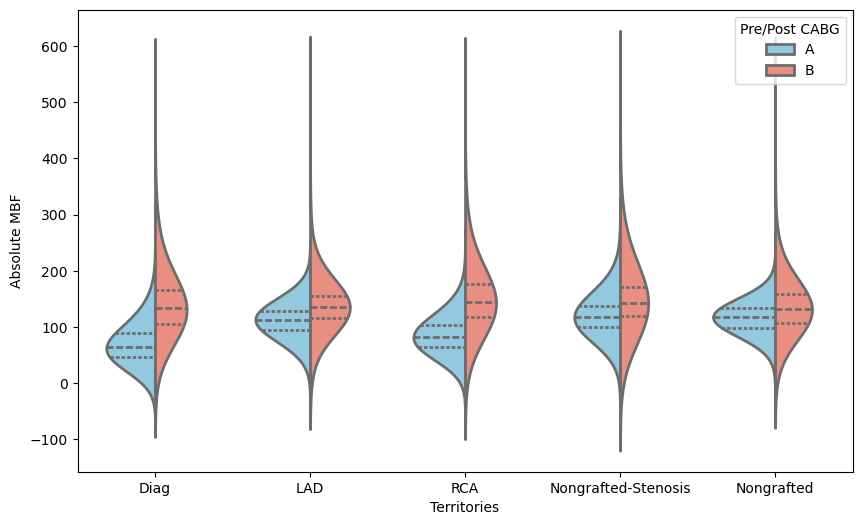

--- Mapping Results:


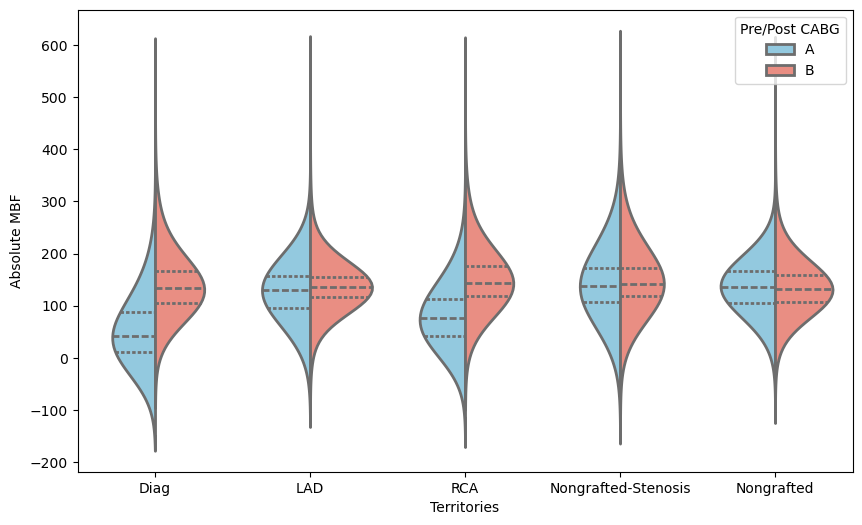

SU04


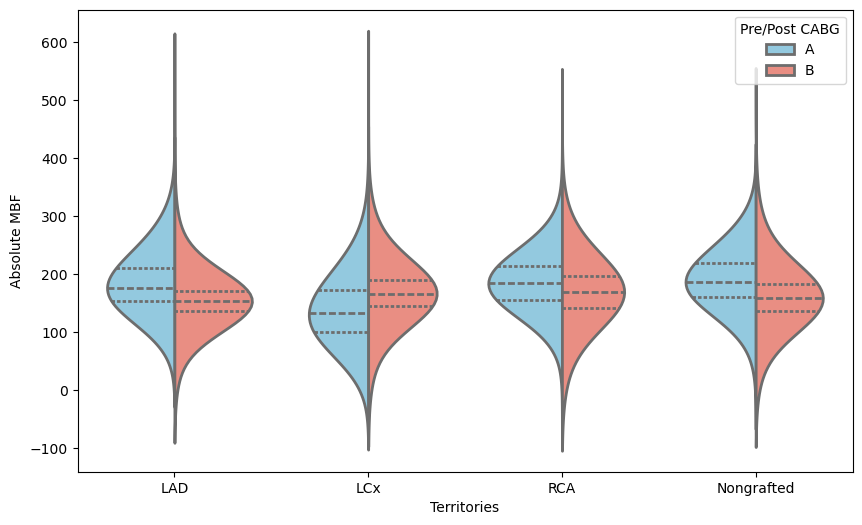

--- Mapping Results:


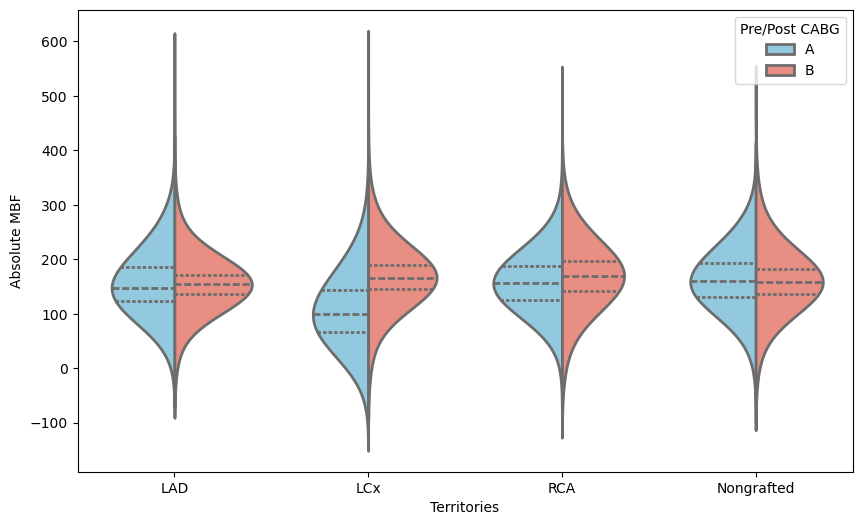

SU06


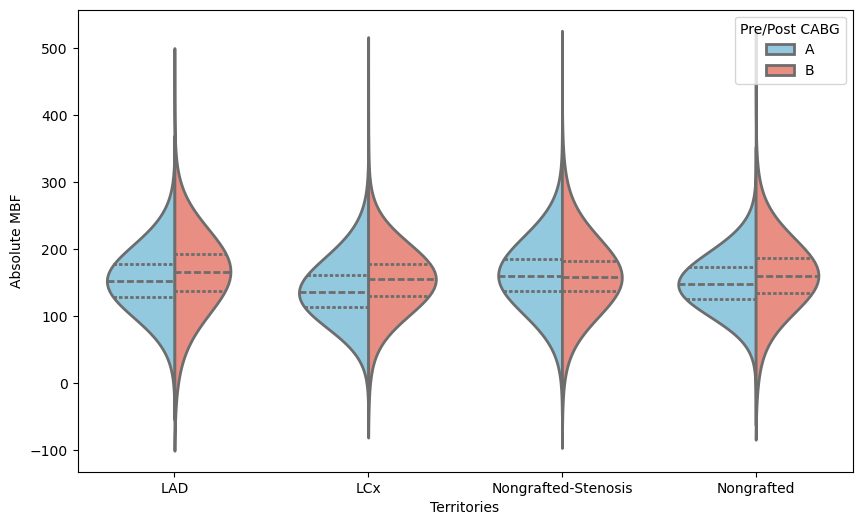

--- Mapping Results:


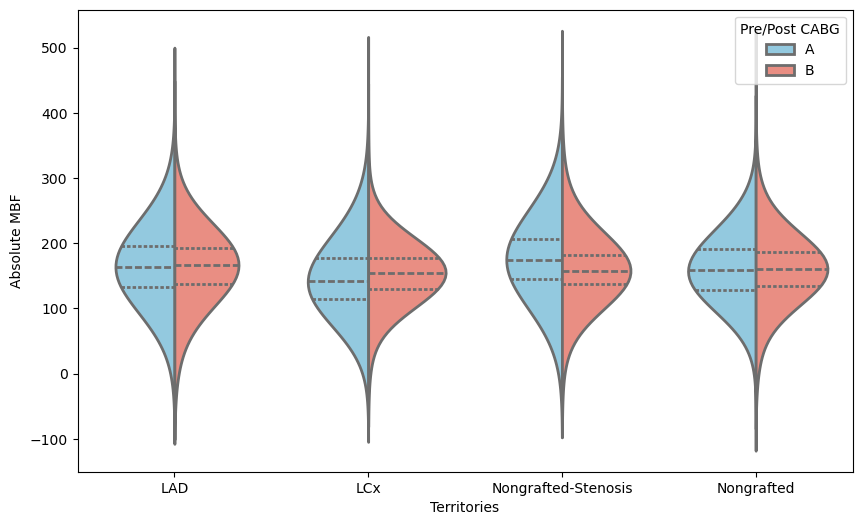

SU07


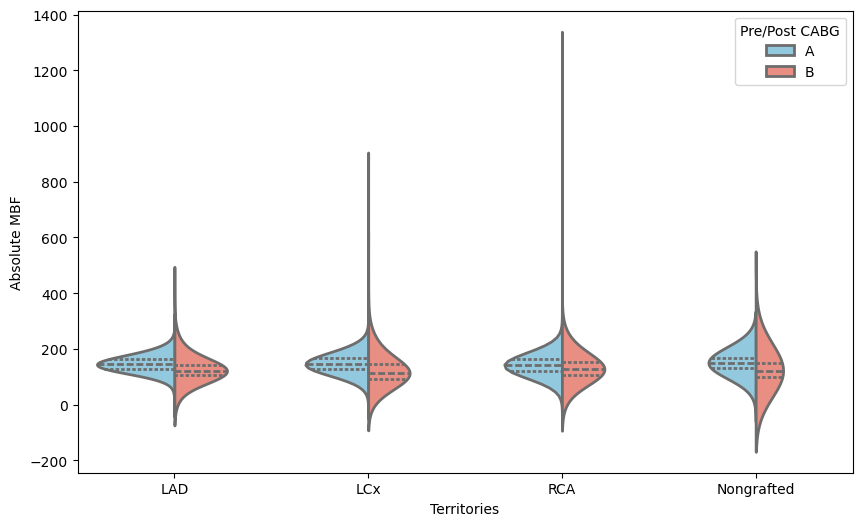

--- Mapping Results:


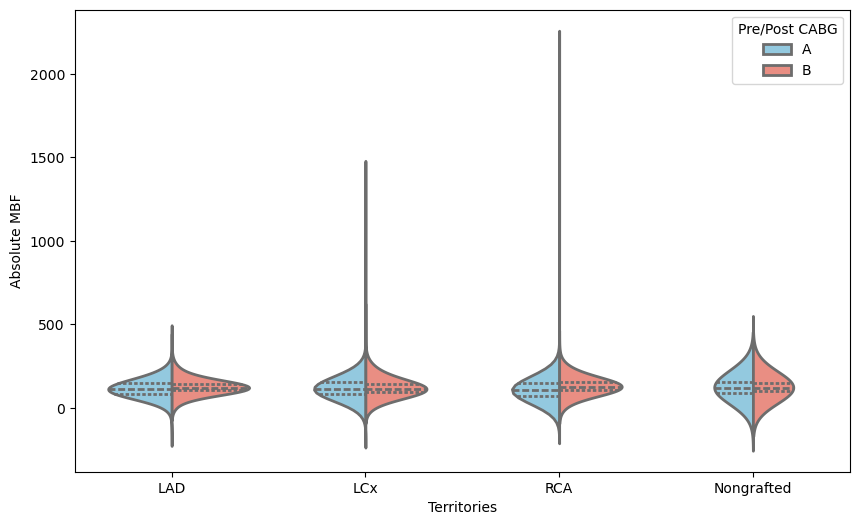

SU11


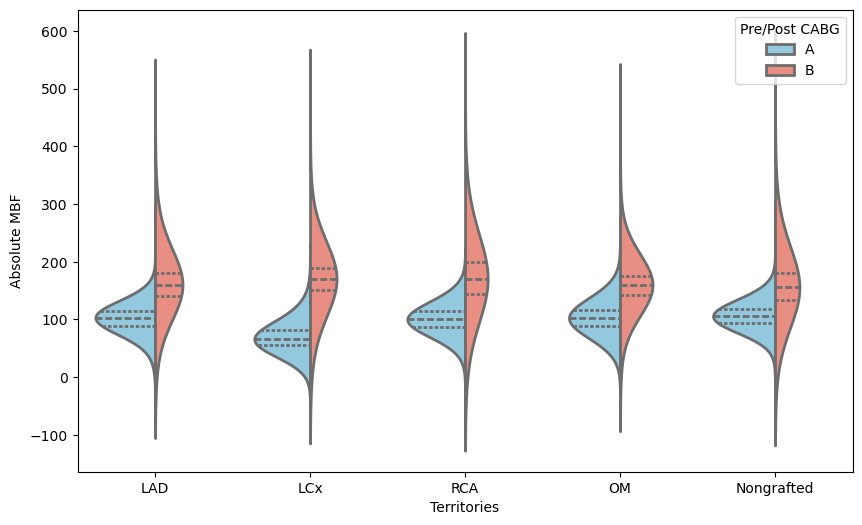

--- Mapping Results:


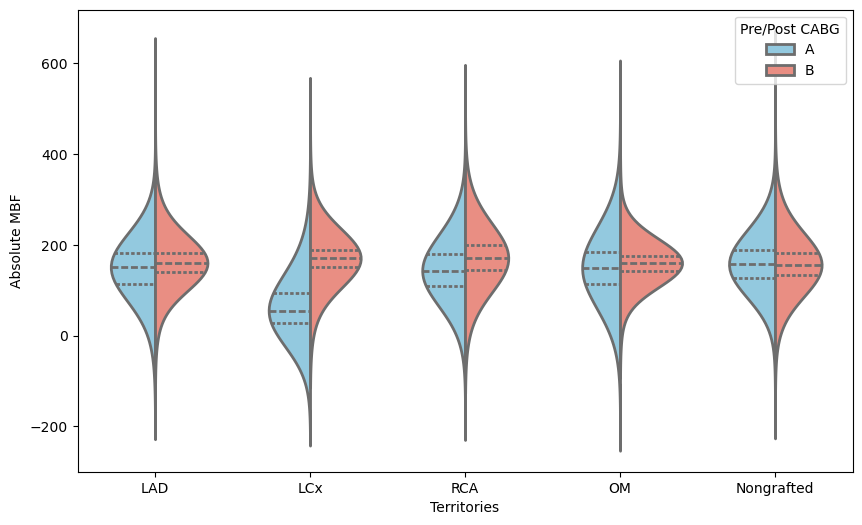

SU13


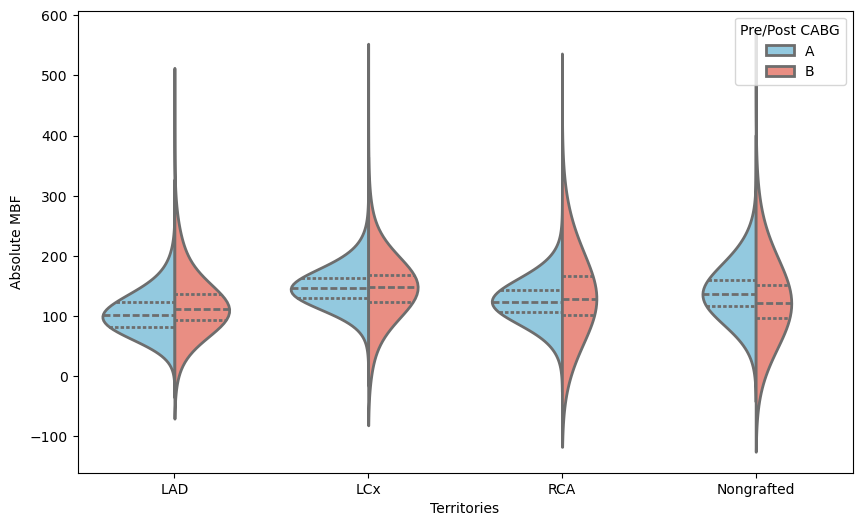

--- Mapping Results:


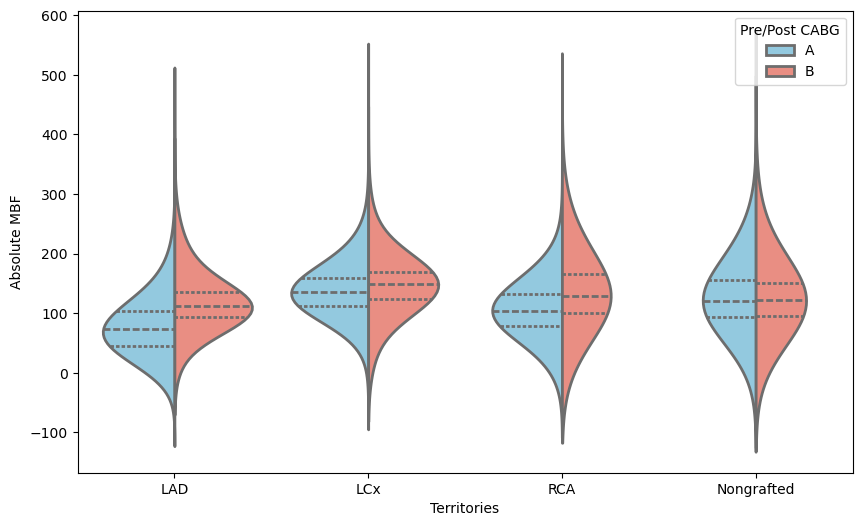

SU14


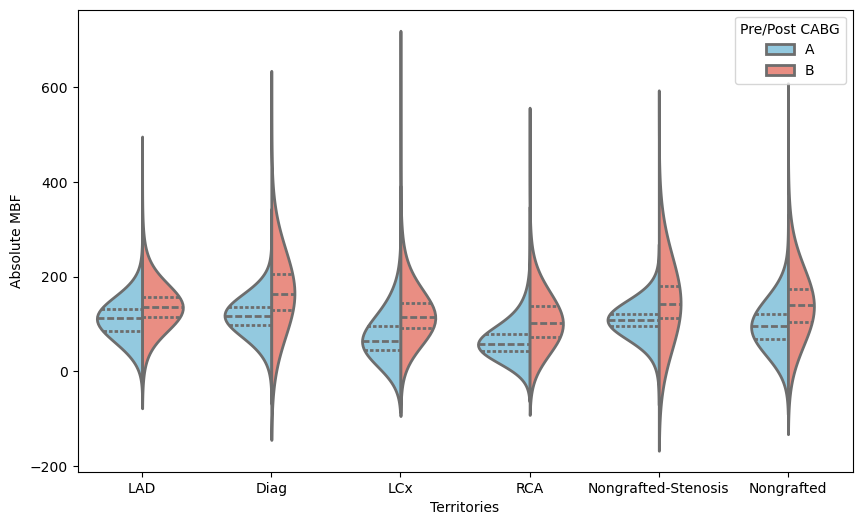

--- Mapping Results:


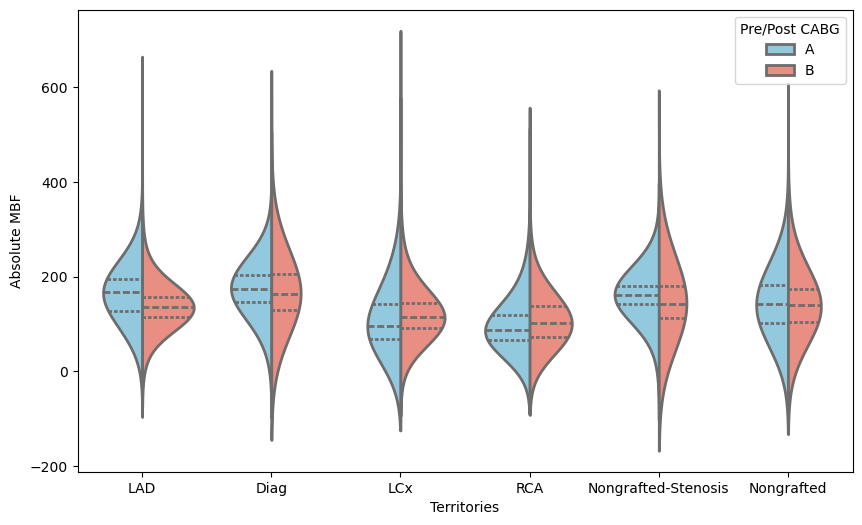

SU23


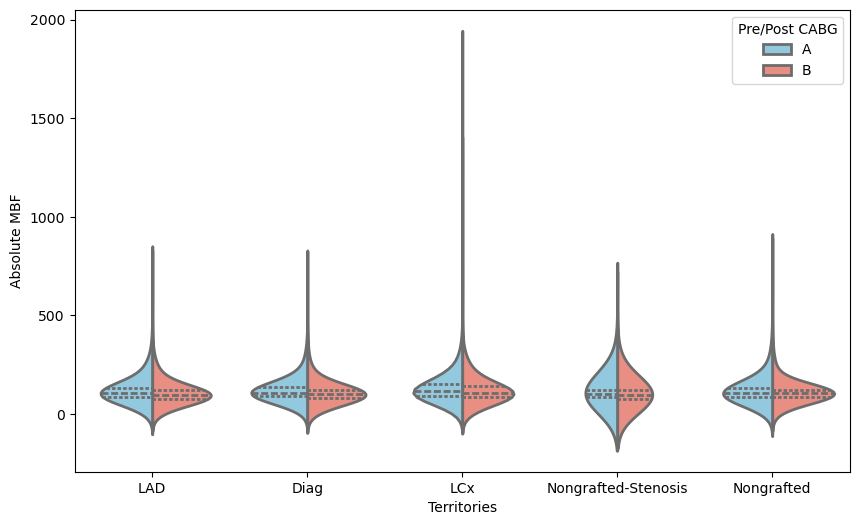

--- Mapping Results:


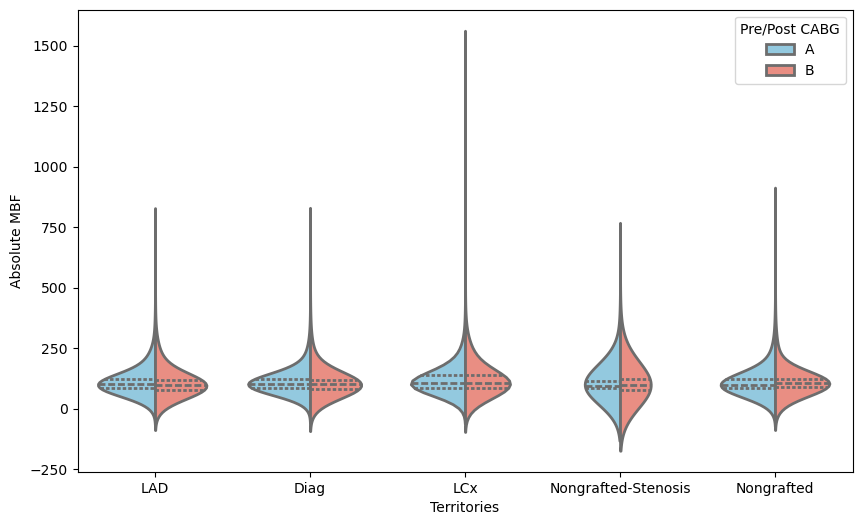

SU24


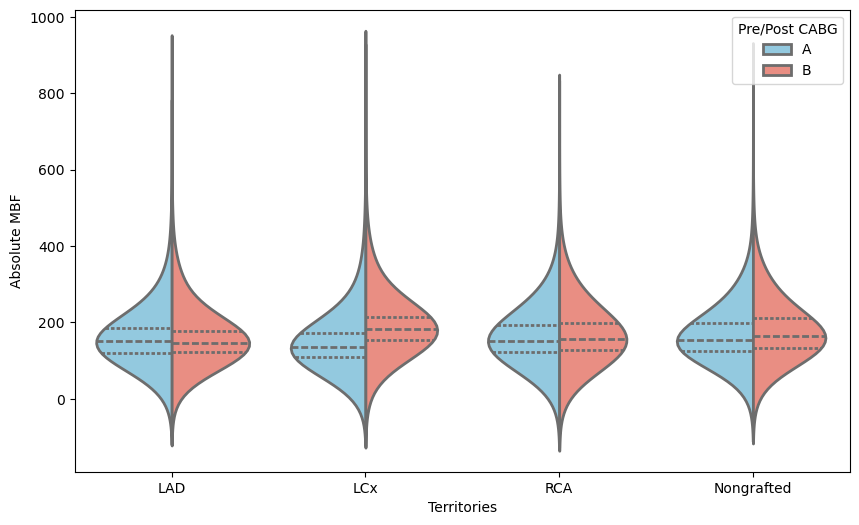

--- Mapping Results:


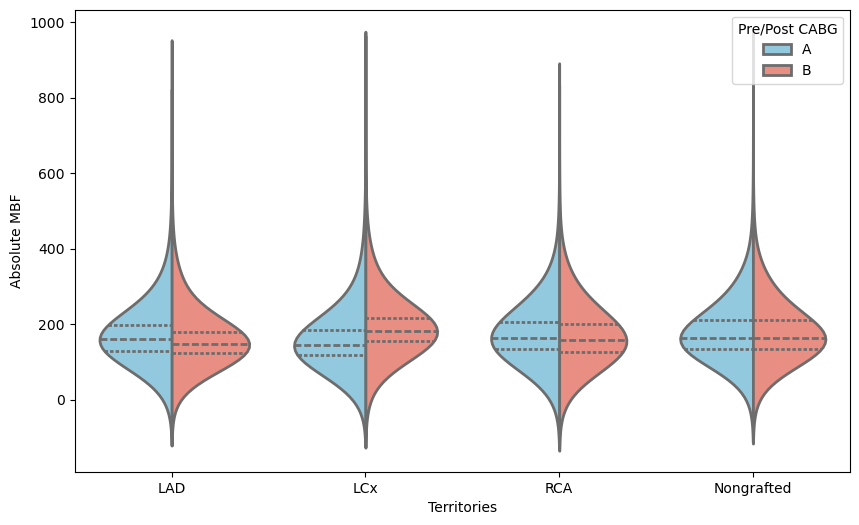

SU25


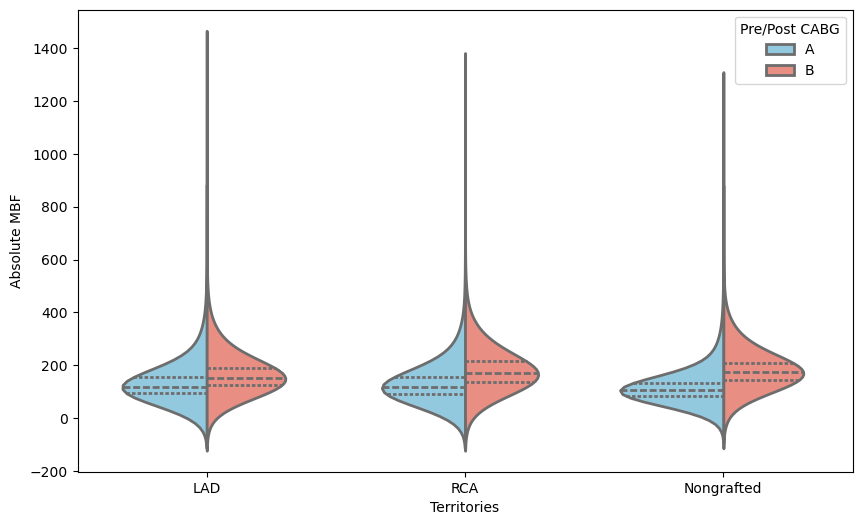

--- Mapping Results:


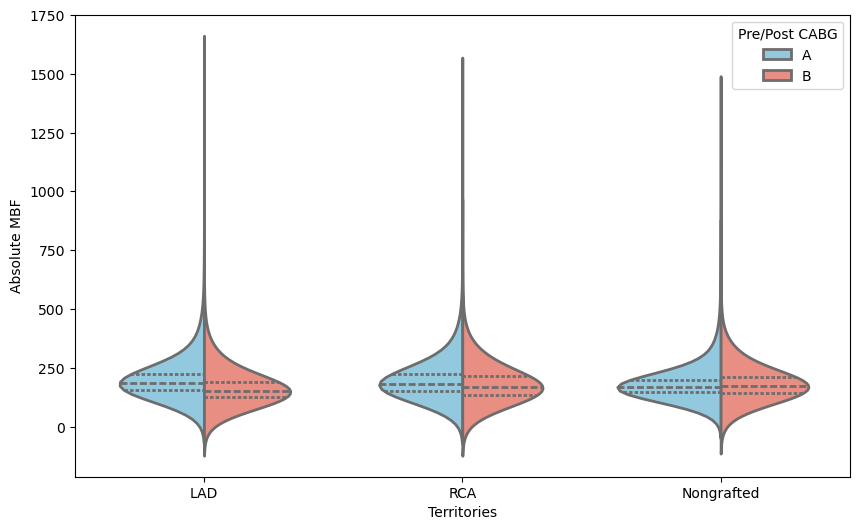

SU26


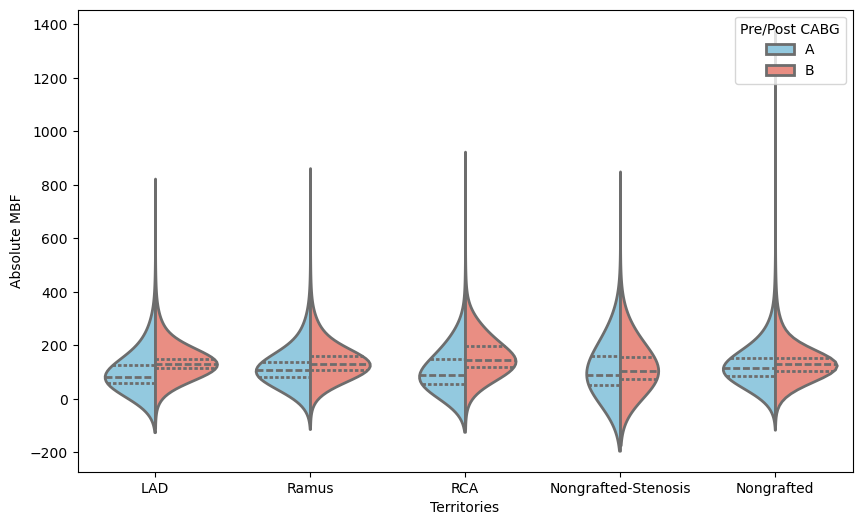

--- Mapping Results:


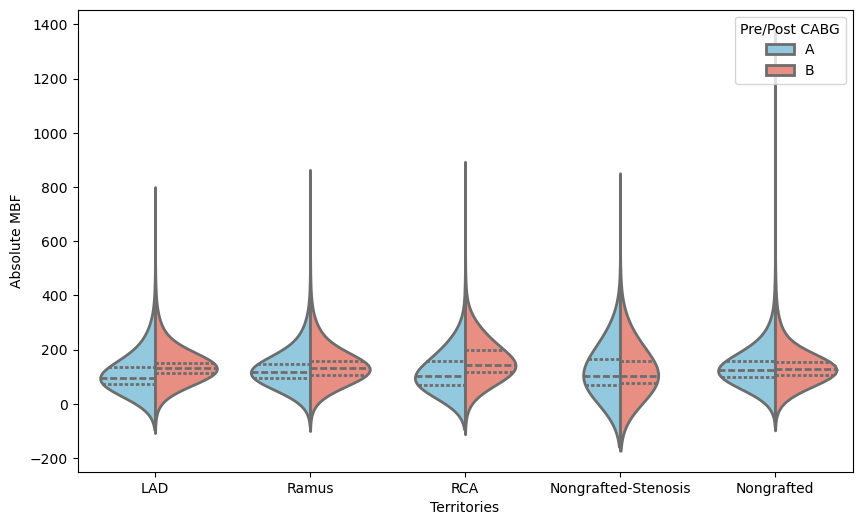

SU27


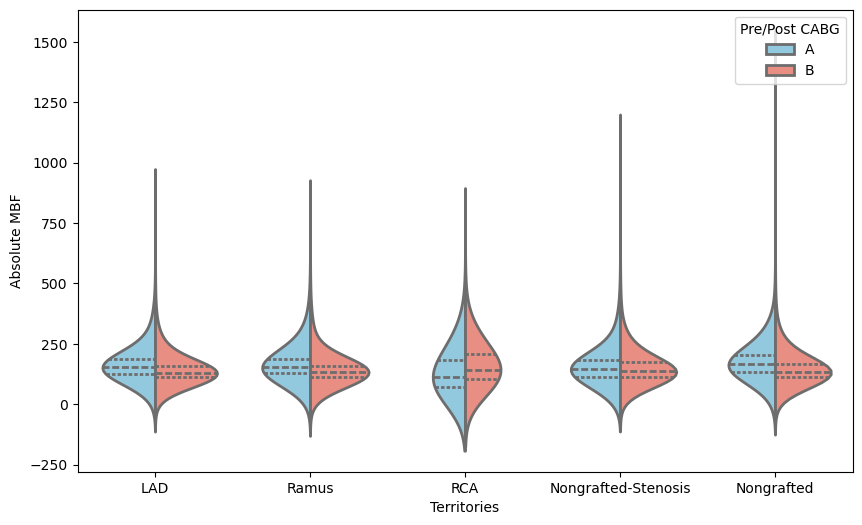

--- Mapping Results:


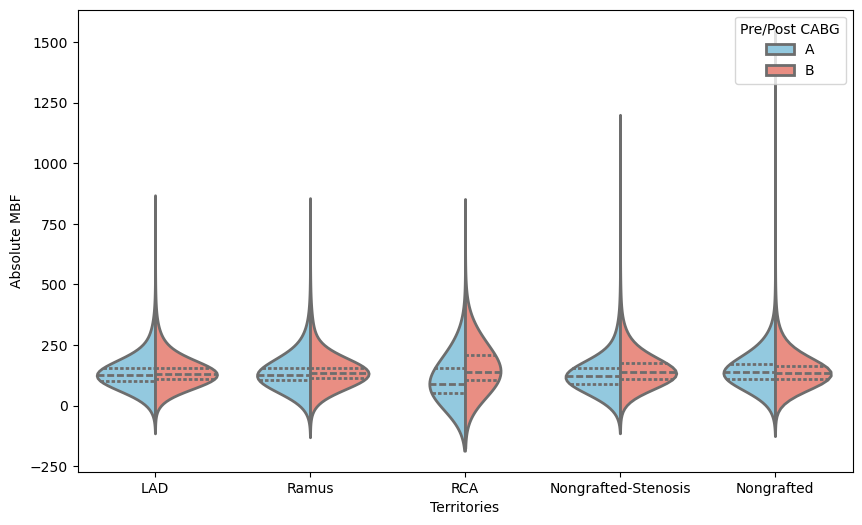

SU28


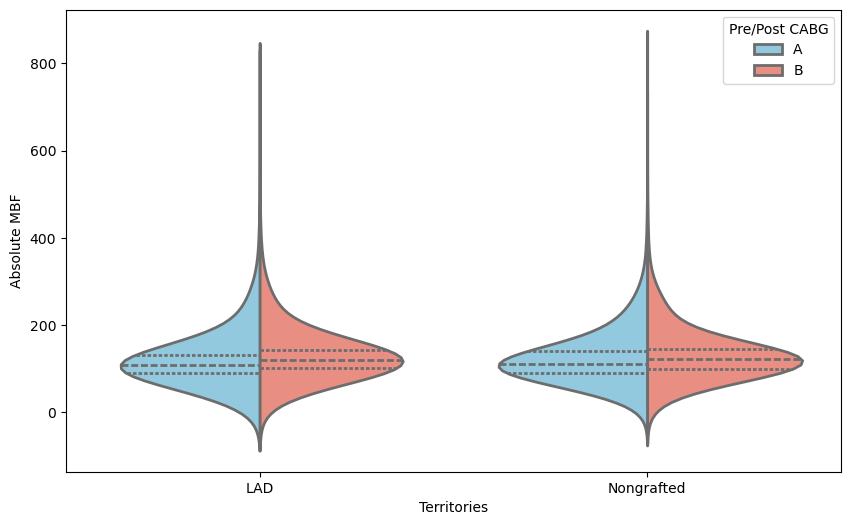

--- Mapping Results:


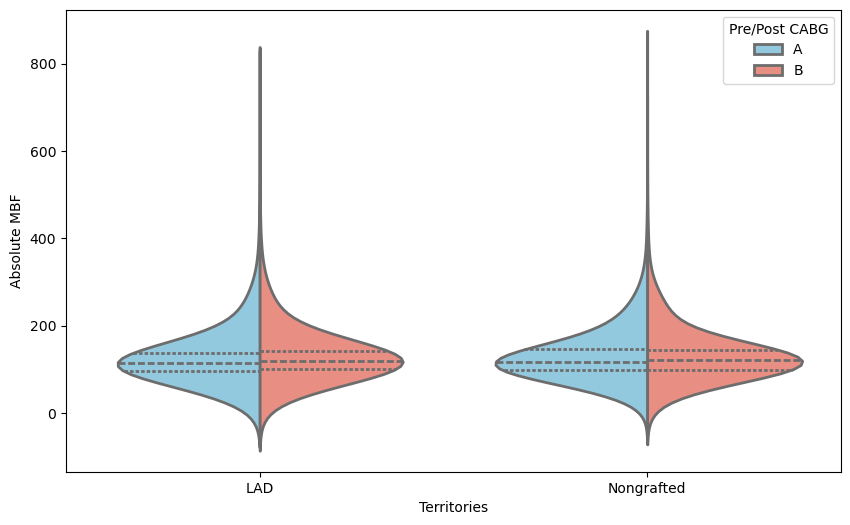

SU30


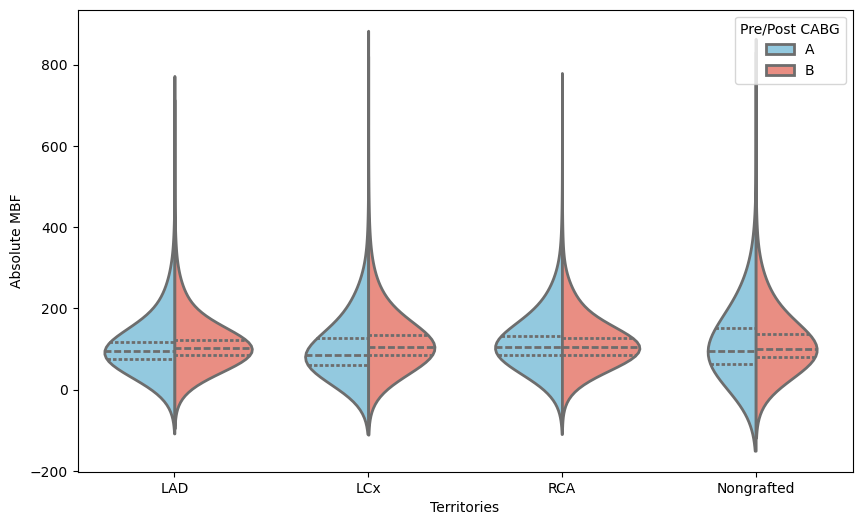

--- Mapping Results:


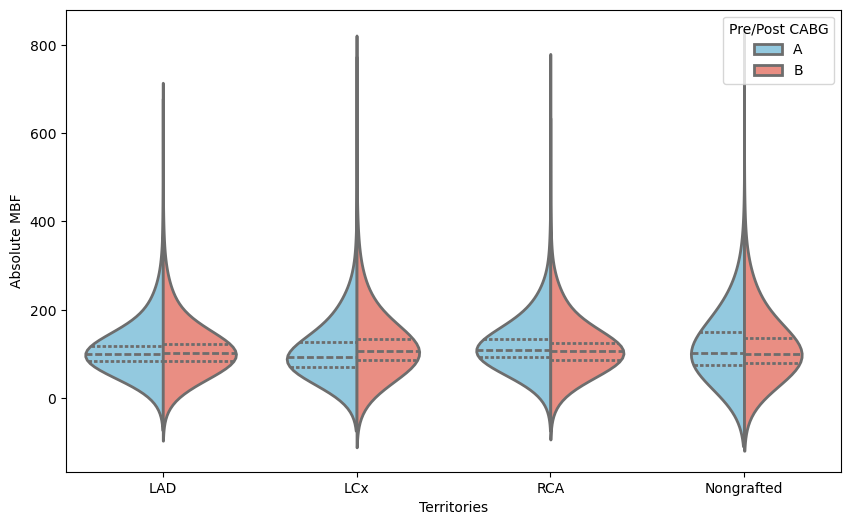

VA02


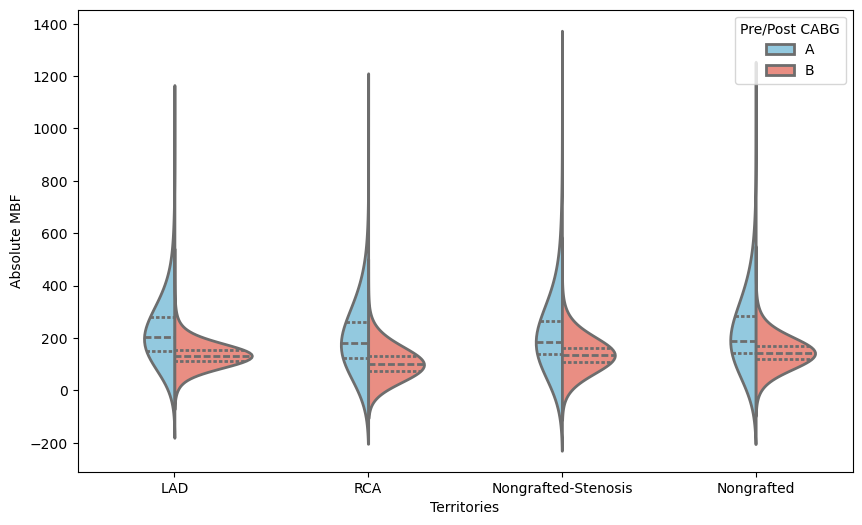

--- Mapping Results:


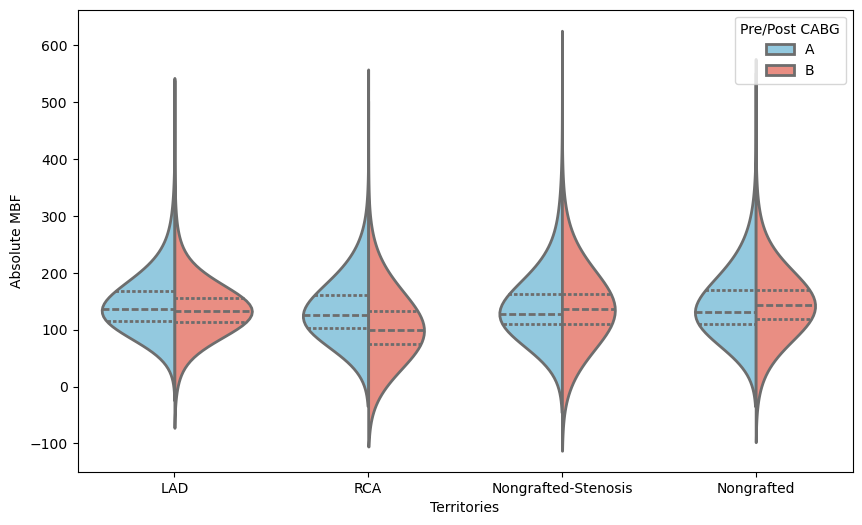

VA04


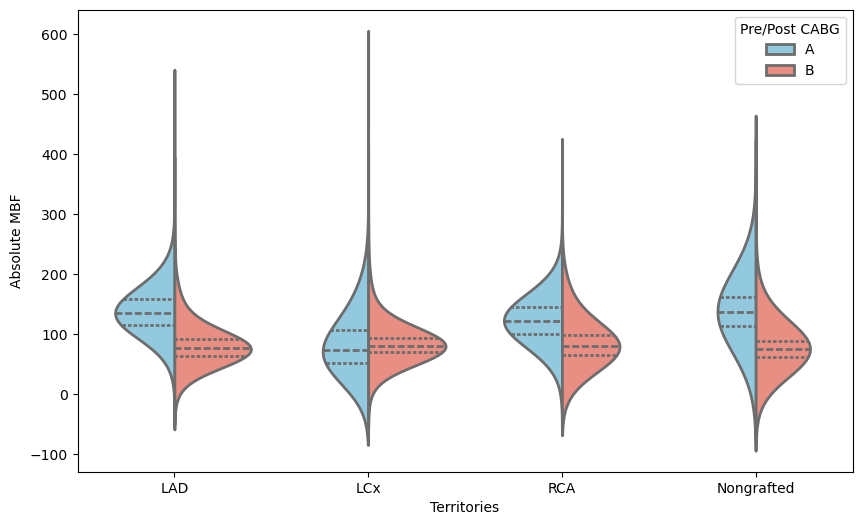

--- Mapping Results:


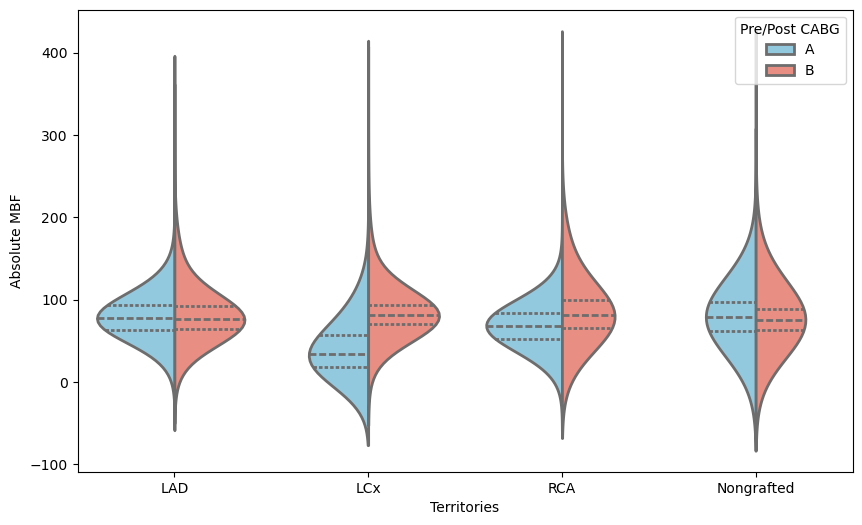

VA10


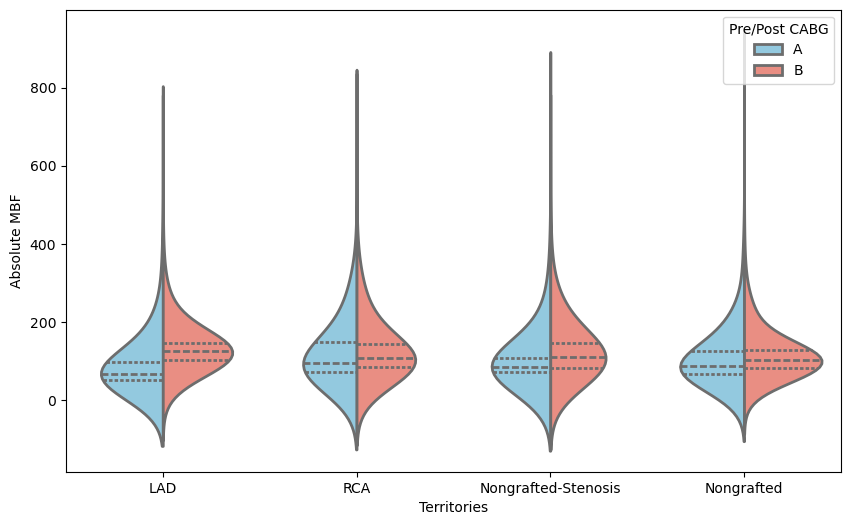

--- Mapping Results:


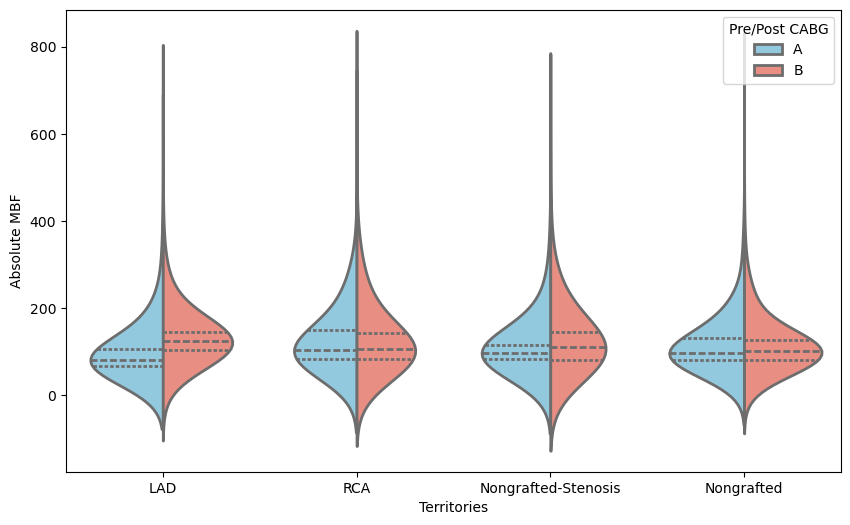

VA13


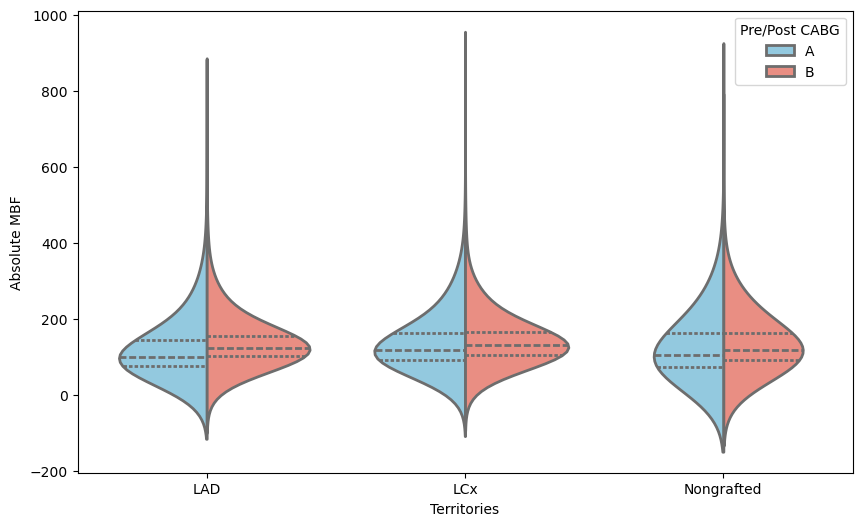

--- Mapping Results:


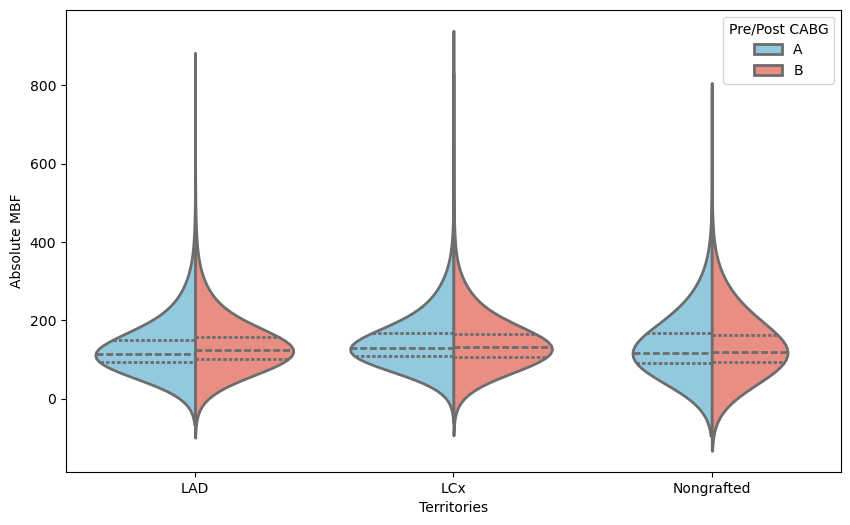

VA14


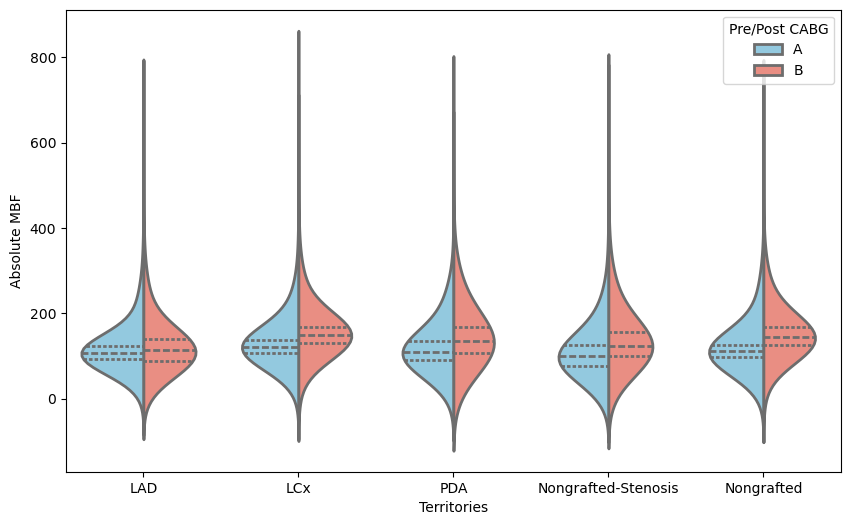

--- Mapping Results:


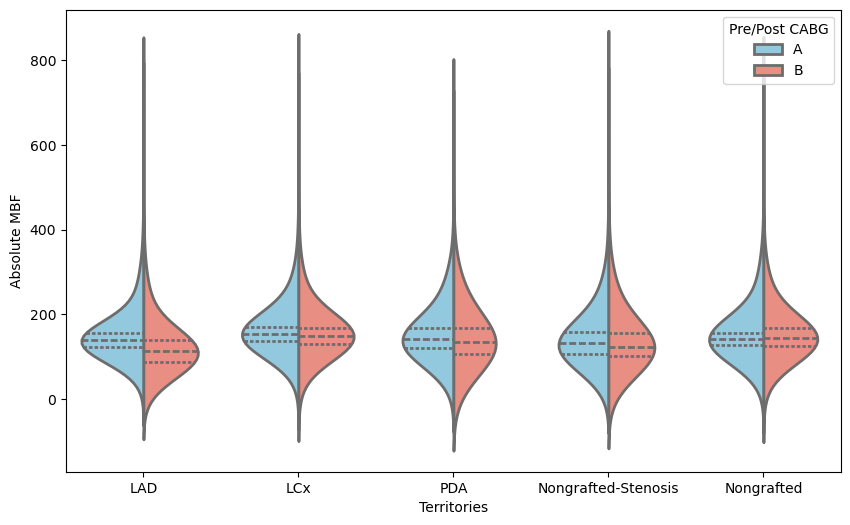

VA16


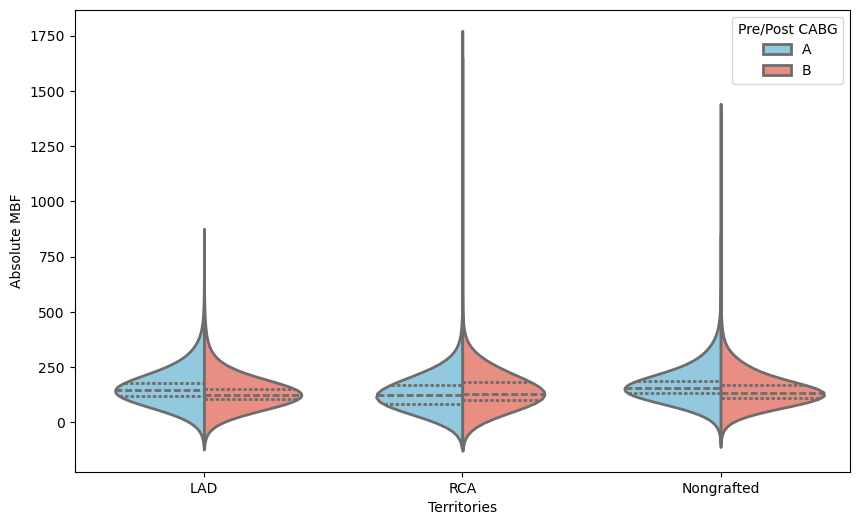

--- Mapping Results:


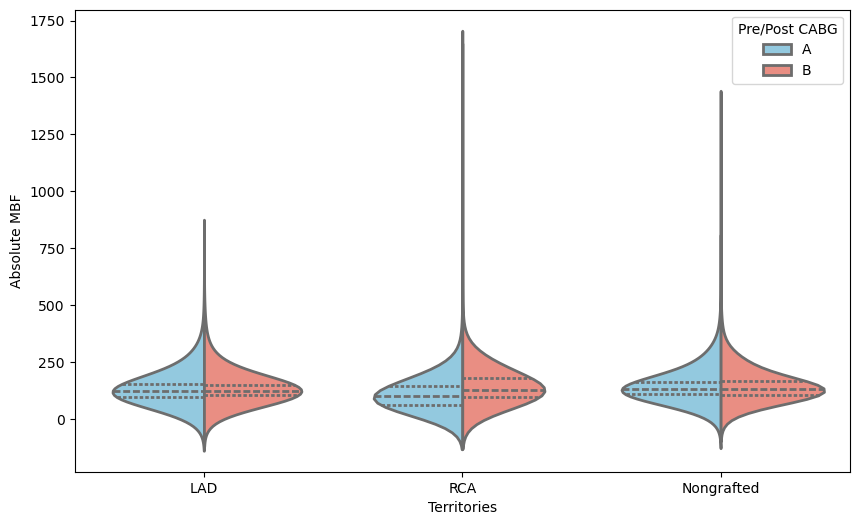

In [51]:
def MapNongrafted(meanA, meanB, stdA, stdB, DataA):
    return meanB + (stdB/stdA)*(DataA - meanA)

def Map3DVolume(meanA, meanB, stdA, stdB, VolumeA):
    for i in range(VolumeA.GetPointData().GetNumberOfArrays()):
            arrayname_ = VolumeA.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    ScalarData = vtk_to_numpy(VolumeA.GetPointData().GetArray(ScalarArray))
    ScalarData_Mapped = numpy_to_vtk(MapNongrafted(meanA, meanB, stdA, stdB, ScalarData))
    ScalarData_Mapped.SetName("MappedScalar")
    VolumeA.GetPointData().AddArray(ScalarData_Mapped)

    return VolumeA


for patient_id in patient_ids:
    print(patient_id)
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    data = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    dataMapped = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)
    MBF_A_mapped = Map3DVolume(mean_A, mean_B, std_A, std_B, MBF_A)
    WriteVTUFile(os.path.join(opath,f"{patient_id}A_MBF_Mapped.vtu"), MBF_A_mapped)
    #data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    #data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    for i, t in enumerate(tags):
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    array_B = AbsMBFData_B[t]
    data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    
    
    #BoxPlot(data)
    ViolinPlot(data)
    print("--- Mapping Results:")
    ViolinPlot(dataMapped)


# Aggregating The Results

In [39]:
dataMapped = []

for patient_id in patient_ids:
    if patient_id in ["SU25", "VA04"]: # Cases that didn't reach hyperaemia
        continue
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)

    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)

    for i, t in enumerate(tags):
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": ischemia[i], "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t]}
        dataMapped.append(data_)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": False, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t]}
        dataMapped.append(data_)
    t = "Nongrafted"
    AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
    data_ = {"patient_id": patient_id, "tag": t, "is_ischemic": False, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t]}
    dataMapped.append(data_)

# --- Post-process after collecting all data: Measuring 30% drop in ischemic regions
non_ischemic_values = np.concatenate([item["absMBF_A"] for item in dataMapped if item["is_ischemic"] == False])
threshold = 0.8 * np.median(non_ischemic_values)  # 30% drop

for item in dataMapped:
    if item["is_ischemic"]:
        if np.median(item["absMBF_A"]) > threshold:
            item["is_ischemic"] = False
        else:
            print(item["patient_id"], item["tag"])

df = pd.DataFrame(dataMapped)


SU03 Diag
SU03 RCA
SU04 LCx
SU11 LCx
SU13 LAD
SU14 RCA
SU23 Diag
SU26 LAD
SU26 RCA
SU27 RCA
SU30 LCx
VA10 LAD
VA16 RCA


In [40]:
df

,patient_id,tag,is_ischemic,absMBF_A,absMBF_B
0,SU03,Diag,True,"[-1.58393972761084, 0.18660967361753933, -1.58...","[162.0, 155.0, 168.0, 162.0, 162.0, 180.0, 164..."
1,SU03,LAD,False,"[140.06001237066005, 140.06001237066005, 140.0...","[83.0, 122.0, 188.0, 212.0, 153.0, 150.0, 134...."
2,SU03,RCA,True,"[67.46748692029621, 67.46748692029621, 76.3202...","[229.0, 224.0, 226.0, 222.0, 102.0, 108.0, 103..."
3,SU03,Nongrafted-Stenosis,False,"[28.515400093271722, 40.90924590187042, 32.056...","[74.0, 74.0, 74.0, 73.0, 70.0, 72.0, 73.0, 75...."
4,SU03,Nongrafted,False,"[127.66616656206133, 125.89561716083294, 118.8...","[291.0, 177.0, 126.0, 107.0, 95.0, 100.0, 161...."
...,...,...,...,...,...
71,VA14,Nongrafted-Stenosis,False,"[252.85203989166655, 251.80715391816994, 249.7...","[12.0, 19.0, 6.0, 14.0, 265.0, 268.0, 268.0, 2..."
72,VA14,Nongrafted,False,"[143.1390126745242, 140.0043547540344, 143.139...","[138.0, 137.0, 139.0, 140.0, 140.0, 138.0, 140..."
73,VA16,LAD,False,"[395.25598035249624, 346.63679156960404, 230.9...","[392.0, 261.0, 228.0, 156.0, 156.0, 133.0, 117..."
74,VA16,RCA,True,"[339.8301051399992, 203.69637654790105, 262.03...","[7.0, 1.0, 2.0, 2.0, 269.0, 262.0, 265.0, 263...."


In [41]:
# Generic

print("TerritoryTag", "Median", "IQR", "Mean", "std")
index_mbf_ischemic_A = np.concatenate(df[df['is_ischemic'] == True]['absMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_A, [25, 50, 75])
average = np.mean(index_mbf_ischemic_A)
std = np.std(index_mbf_ischemic_A)
print("ischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_ischemic_B = np.concatenate(df[df['is_ischemic'] == True]['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic_B, [25, 50, 75])
average = np.mean(index_mbf_ischemic_B)
std = np.std(index_mbf_ischemic_B)
print("ischemic_grafted_B",q2, q3-q1, average, std)

index_mbf_nonischemic_A = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_A, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_A)
std = np.std(index_mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_nonischemic_B = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_B, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_B)
std = np.std(index_mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)

index_mbf_st_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_st_nongrafted_A, [25, 50, 75])
average = np.mean(index_mbf_st_nongrafted_A)
std = np.std(index_mbf_st_nongrafted_A)
print("stenosed_nongrafted_A", q2, q3-q1, average, std)

index_mbf_st_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_st_nongrafted_B, [25, 50, 75])
average = np.mean(index_mbf_st_nongrafted_B)
std = np.std(index_mbf_st_nongrafted_B)
print("stenosed_nongrafted_B", q2, q3-q1, average, std)


index_mbf_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_A'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_A, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_A)
std = np.std(index_mbf_nongrafted_A)
print("nongrafted_A", q2, q3-q1, average, std)

index_mbf_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nongrafted_B, [25, 50, 75])
average = np.mean(index_mbf_nongrafted_B)
std = np.std(index_mbf_nongrafted_B)
print("nongrafted_B", q2, q3-q1, average, std)



TerritoryTag Median IQR Mean std
ischemic_grafted_A 86.94353033380845 63.77513642554274 96.0784061966401 58.555551383891796
ischemic_grafted_B 124.0 63.0 134.72108839096714 58.528298496935356
nonischemic_grafted_A 126.47272764953624 63.17521508681878 135.98217799328188 58.12109699174347
nonischemic_grafted_B 128.0 61.0 137.07495127817472 58.603924133706876
stenosed_nongrafted_A 124.66600423664995 63.81909062298965 133.84092757477444 60.57439505824673
stenosed_nongrafted_B 132.0 64.0 142.78359412326805 62.07936624613595
nongrafted_A 128.51060904557187 67.66369360105712 139.9262607046641 59.890064759307684
nongrafted_B 128.0 60.0 138.96236070442276 60.18072975137904


In [42]:
# Create a DataFrame with each part
df_A = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_A, index_mbf_nonischemic_A, index_mbf_st_nongrafted_A, index_mbf_nongrafted_A]),
    'Territory': ['Ischemic\n Grafted'] * len(index_mbf_ischemic_A) + 
             ['Nonischemic\n Grafted'] * len(index_mbf_nonischemic_A) + 
             ['Nongrafted\n Stenosis'] * len(index_mbf_st_nongrafted_A) +
             ['Nongrafted'] * len(index_mbf_nongrafted_A),
    'Type': ['Pre-CABG'] * (len(index_mbf_ischemic_A) + len(index_mbf_nonischemic_A) + len(index_mbf_st_nongrafted_A) + len(index_mbf_nongrafted_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([index_mbf_ischemic_B, index_mbf_nonischemic_B, index_mbf_st_nongrafted_B, index_mbf_nongrafted_B]),
    'Territory': ['Ischemic\n Grafted'] * len(index_mbf_ischemic_B) + 
             ['Nonischemic\n Grafted'] * len(index_mbf_nonischemic_B) + 
             ['Nongrafted\n Stenosis'] * len(index_mbf_st_nongrafted_B) +
             ['Nongrafted'] * len(index_mbf_nongrafted_B),
    'Type': ['Post-CABG'] * (len(index_mbf_ischemic_B) + len(index_mbf_nonischemic_B) + len(index_mbf_st_nongrafted_B) + len(index_mbf_nongrafted_B))
})

# Combine into a single DataFrame
df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:

plt.figure(figsize=(10, 6))

sns.violinplot(x='Territory', y='MBF', hue='Type', data = df_long, split=True, inner = 'quartiles', bw_adjust = 10, common_norm=True, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})

plt.ylabel("Absolute MBF")
#plt.xlabel("Group")
plt.legend(title="Pre/Post CABG")
plt.ylim([-80, 400])
plt.show()

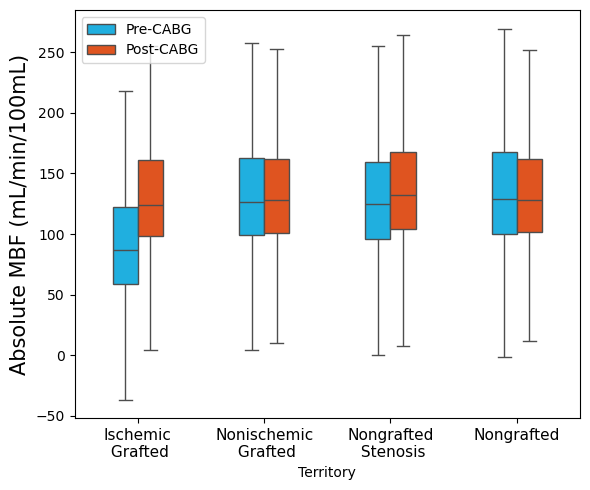

In [43]:


plt.figure(figsize=(6, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'deepskyblue', 'Post-CABG':'orangered'})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
fig = px.violin(df_long, y = "MBF", x = "Territory", color = "Type", 
                violinmode='overlay', points=False, box=False)

fig.show()

